#1.mengimpor library

In [1]:
# Impor library yang diperlukan
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Library untuk Pre-processing Data
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Library untuk Model Prediktif (contoh)
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor # Pastikan Anda telah menginstal xgboost: pip install xgboost

# Library untuk Metrik Evaluasi
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Pengaturan visualisasi
plt.style.use('ggplot')
sns.set_palette('viridis')


#2.Import data dari gdrive

In [18]:
file_id = '1DpsgXsI1WlbFz7_jdLa9_fPY5-MGvV3Y'
download_url = f'https://drive.google.com/uc?export=download&id={file_id}'

    # Coba dengan pemisah titik koma (;)
try:
        df = pd.read_csv(download_url, sep=';')
        print("Dataset berhasil dimuat dengan pemisah titik koma.")
        print(df.head())
except Exception as e_semicolon:
        print(f"Gagal dengan pemisah titik koma: {e_semicolon}")


Dataset berhasil dimuat dengan pemisah titik koma.
        departure_time          return_time  departure_station_id  \
0  2021-04-30T23:59:54  2021-05-01T00:08:15                    16   
1  2021-04-30T23:59:52  2021-05-01T00:16:16                    20   
2  2021-04-30T23:59:52  2021-05-01T00:13:40                     4   
3  2021-04-30T23:59:43  2021-05-01T00:23:22                   133   
4  2021-04-30T23:59:41  2021-05-01T00:16:15                    20   

  departure_station_name  return_station_id return_station_name  distance  \
0        Liisanpuistikko                  2     Laivasillankatu    1885.0   
1      Kaisaniemenpuisto                112  Rautatieläisenkatu    3359.0   
2              Viiskulma                 33   Kauppakorkeakoulu    1633.0   
3         Paavalinpuisto                241       Agronominkatu    6459.0   
4      Kaisaniemenpuisto                112  Rautatieläisenkatu    3210.0   

   duration  
0       499  
1       984  
2       824  
3      1418  
4

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 548350 entries, 0 to 548349
Data columns (total 8 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   departure_time          548350 non-null  object 
 1   return_time             548350 non-null  object 
 2   departure_station_id    548350 non-null  int64  
 3   departure_station_name  548350 non-null  object 
 4   return_station_id       548350 non-null  int64  
 5   return_station_name     548350 non-null  object 
 6   distance                547608 non-null  float64
 7   duration                548350 non-null  int64  
dtypes: float64(1), int64(3), object(4)
memory usage: 33.5+ MB


#2.Pengumpulan dan Pemuatan Data

In [20]:
np.random.seed(42) # Untuk reproduktibilitas

dates = pd.date_range(start='2022-01-01', end='2024-12-31', freq='D')
num_products = 50
product_ids = [f'PROD_{i:03d}' for i in range(num_products)]

data = []
for date in dates:
    for prod_id in product_ids:
        # Simulasi penjualan dasar
        base_sales = np.random.randint(50, 200)

        # Faktor musiman (bulanan)
        month_factor = 1 + np.sin((date.month - 1.5) * (2 * np.pi / 12)) * 0.3

        # Faktor tren (linear)
        trend_factor = 1 + (date - dates.min()).days / 1000 * 0.05

        # Faktor promosi (acak, 20% kemungkinan promosi)
        promo_cost = 0
        if np.random.rand() < 0.2:
            promo_cost = np.random.randint(100, 1000)
            base_sales *= (1 + np.random.uniform(0.1, 0.5)) # Peningkatan penjualan karena promosi

        # Faktor hari libur (simulasi)
        is_holiday = 1 if date.day_name() in ['Saturday', 'Sunday'] or (date.month == 1 and date.day == 1) else 0
        if is_holiday:
            base_sales *= 1.2 # Peningkatan penjualan saat hari libur

        # Faktor cuaca (suhu rata-rata)
        avg_temp = np.random.uniform(25, 35) # Suhu di Indonesia
        temp_factor = 1 + (avg_temp - 30) / 100 * 0.1 # Sedikit pengaruh suhu

        # Penjualan akhir dengan noise
        final_sales = base_sales * month_factor * trend_factor * temp_factor + np.random.normal(0, 10)
        final_sales = max(10, int(final_sales)) # Pastikan penjualan tidak negatif

        # Harga produk
        price = np.random.uniform(50000, 500000)

        data.append({
            'tanggal': date,
            'id_produk': prod_id,
            'jumlah_penjualan': final_sales,
            'harga_satuan': round(price, -2), # Bulatkan ke ratusan terdekat
            'biaya_promosi': promo_cost,
            'suhu_rata2': round(avg_temp, 1),
            'hari_libur': is_holiday,
            'bulan': date.month,
            'tahun': date.year,
            'hari_dalam_minggu': date.dayofweek # 0=Senin, 6=Minggu
        })

df = pd.DataFrame(data)

print(f"Ukuran dataset: {df.shape}")
print("\nLima baris pertama dataset:")
print(df.head())
print("\nInformasi dataset:")
df.info()


Ukuran dataset: (54800, 10)

Lima baris pertama dataset:
     tanggal id_produk  jumlah_penjualan  harga_satuan  biaya_promosi  \
0 2022-01-01  PROD_000               172      250600.0              0   
1 2022-01-01  PROD_001               150      114300.0              0   
2 2022-01-01  PROD_002               292       53200.0            869   
3 2022-01-01  PROD_003               168      112800.0              0   
4 2022-01-01  PROD_004                71      316600.0              0   

   suhu_rata2  hari_libur  bulan  tahun  hari_dalam_minggu  
0        26.8           1      1   2022                  5  
1        28.3           1      1   2022                  5  
2        34.4           1      1   2022                  5  
3        31.1           1      1   2022                  5  
4        32.9           1      1   2022                  5  

Informasi dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54800 entries, 0 to 54799
Data columns (total 10 columns):
 #   Colu

#4.Pra-pemrosesan Data (Data Pre-processing)

In [21]:
# Langkah ini melibatkan pembersihan, transformasi, dan persiapan data untuk pemodelan.

# Mengubah tipe data 'tanggal' menjadi datetime jika belum
df['tanggal'] = pd.to_datetime(df['tanggal'])

# Fitur rekayasa (Feature Engineering)
# Contoh: Hari dalam setahun, minggu dalam setahun
df['hari_dalam_tahun'] = df['tanggal'].dt.dayofyear
df['minggu_dalam_tahun'] = df['tanggal'].dt.isocalendar().week.astype(int)

# Membuat fitur lag (penjualan dari hari/minggu sebelumnya)
# Ini penting untuk deret waktu
df = df.sort_values(by=['id_produk', 'tanggal'])
df['jumlah_penjualan_lag_7'] = df.groupby('id_produk')['jumlah_penjualan'].shift(7) # Penjualan 7 hari sebelumnya
df['jumlah_penjualan_lag_30'] = df.groupby('id_produk')['jumlah_penjualan'].shift(30) # Penjualan 30 hari sebelumnya

# Mengisi nilai NaN yang muncul dari fitur lag (misalnya dengan 0 atau rata-rata)
# Untuk model prediksi, lebih baik menghapus baris yang memiliki NaN pada target atau fitur penting
df.dropna(subset=['jumlah_penjualan_lag_7', 'jumlah_penjualan_lag_30'], inplace=True)


# Memisahkan fitur (X) dan target (y)
features = [
    'harga_satuan', 'biaya_promosi', 'suhu_rata2', 'hari_libur',
    'bulan', 'tahun', 'hari_dalam_minggu',
    'hari_dalam_tahun', 'minggu_dalam_tahun',
    'jumlah_penjualan_lag_7', 'jumlah_penjualan_lag_30'
]
target = 'jumlah_penjualan'

X = df[features]
y = df[target]

# Mengidentifikasi kolom numerik dan kategorikal
numeric_features = X.select_dtypes(include=np.number).columns.tolist()
categorical_features = X.select_dtypes(include='object').columns.tolist() # 'id_produk' jika disertakan sebagai fitur

# Contoh: jika 'id_produk' ingin dijadikan fitur kategorikal
# X['id_produk'] = df['id_produk'] # Tambahkan kembali jika ingin digunakan sebagai fitur

# Pipeline untuk pre-processing
# Numerik: Scaling
# Kategorikal: One-Hot Encoding
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        # ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features) # Aktifkan jika ada fitur kategorikal non-numerik
    ])

# Memisahkan data menjadi training dan testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"\nUkuran X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"Ukuran X_test: {X_test.shape}, y_test: {y_test.shape}")

### 5. Pemilihan dan Pelatihan Model Prediktif

# Kita akan melatih beberapa model regresi untuk memprediksi `jumlah_penjualan`.

# Inisialisasi model
models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, random_state=42),
    'XGBoost': XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42, n_jobs=-1)
}

# Melatih dan mengevaluasi setiap model
results = {}

for name, model in models.items():
    print(f"\nMelatih model: {name}")

    # Membuat pipeline lengkap (pre-processing + model)
    full_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                    ('regressor', model)])

    # Melatih model
    full_pipeline.fit(X_train, y_train)

    # Melakukan prediksi
    y_pred = full_pipeline.predict(X_test)

    # Evaluasi model
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)

    results[name] = {'MAE': mae, 'MSE': mse, 'RMSE': rmse, 'R2': r2}

    print(f"  MAE: {mae:.2f}")
    print(f"  MSE: {mse:.2f}")
    print(f"  RMSE: {rmse:.2f}")
    print(f"  R2: {r2:.2f}")

# Menampilkan semua hasil
print("\n--- Ringkasan Hasil Evaluasi Model ---")
for name, metrics in results.items():
    print(f"\nModel: {name}")
    for metric_name, value in metrics.items():
        print(f"  {metric_name}: {value:.2f}")


Ukuran X_train: (42640, 11), y_train: (42640,)
Ukuran X_test: (10660, 11), y_test: (10660,)

Melatih model: Linear Regression
  MAE: 46.73
  MSE: 3294.60
  RMSE: 57.40
  R2: 0.23

Melatih model: Random Forest
  MAE: 45.45
  MSE: 3041.66
  RMSE: 55.15
  R2: 0.29

Melatih model: Gradient Boosting
  MAE: 44.48
  MSE: 2874.71
  RMSE: 53.62
  R2: 0.32

Melatih model: XGBoost
  MAE: 44.70
  MSE: 2920.89
  RMSE: 54.05
  R2: 0.31

--- Ringkasan Hasil Evaluasi Model ---

Model: Linear Regression
  MAE: 46.73
  MSE: 3294.60
  RMSE: 57.40
  R2: 0.23

Model: Random Forest
  MAE: 45.45
  MSE: 3041.66
  RMSE: 55.15
  R2: 0.29

Model: Gradient Boosting
  MAE: 44.48
  MSE: 2874.71
  RMSE: 53.62
  R2: 0.32

Model: XGBoost
  MAE: 44.70
  MSE: 2920.89
  RMSE: 54.05
  R2: 0.31


#6.Evaluasi dan Visualisasi Hasil


DataFrame Hasil Evaluasi Model:
                         MAE          MSE       RMSE        R2
Linear Regression  46.728463  3294.600243  57.398608  0.225983
Random Forest      45.445511  3041.663557  55.151279  0.285407
Gradient Boosting  44.475646  2874.707661  53.616300  0.324631
XGBoost            44.697227  2920.891113  54.045269  0.313781


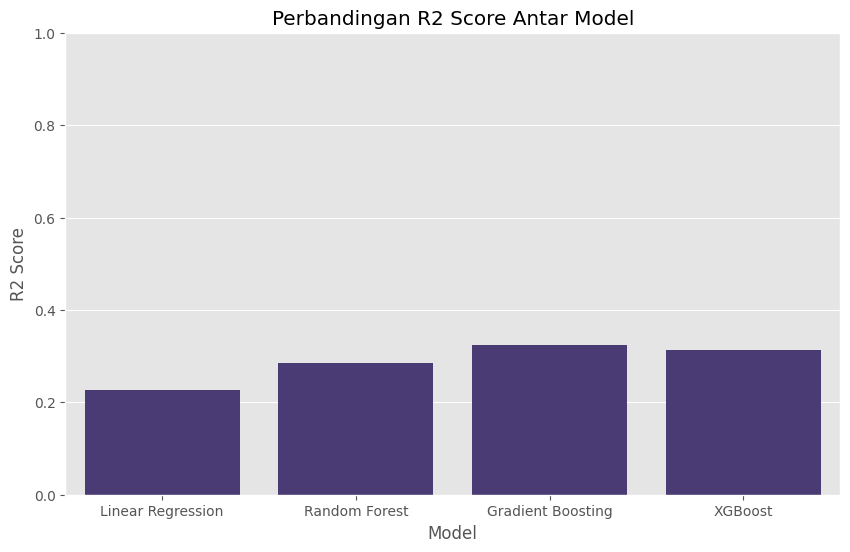

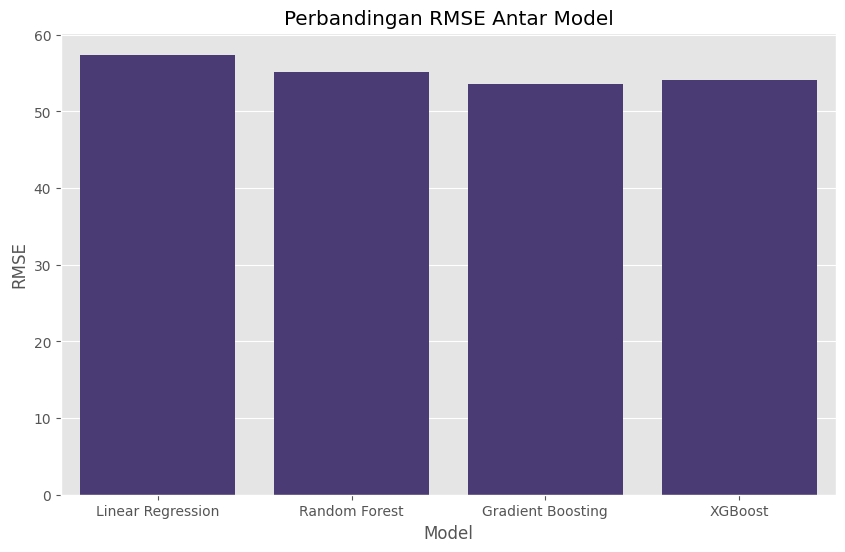

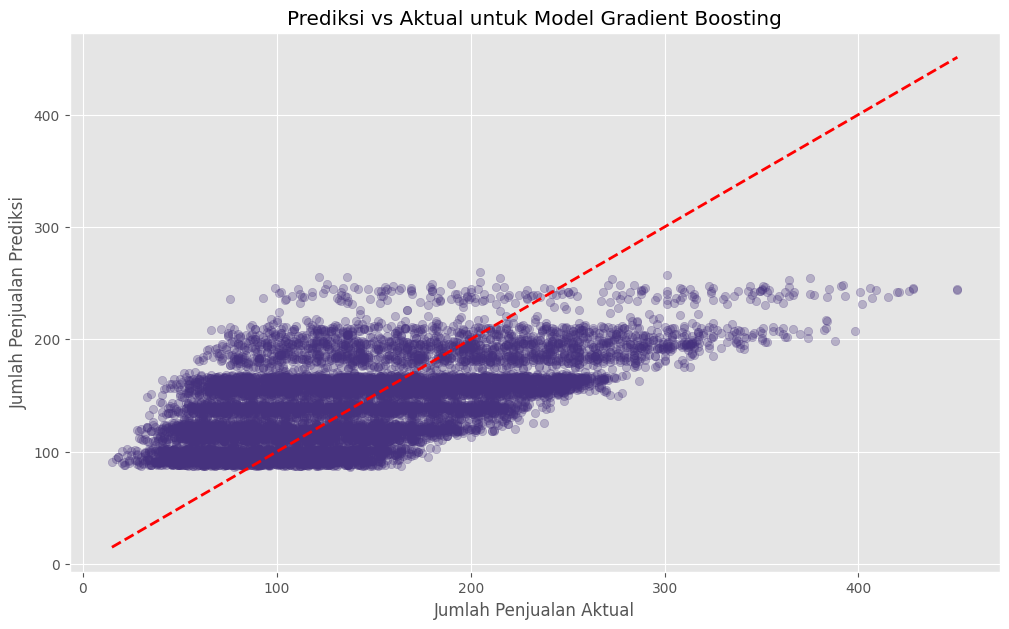

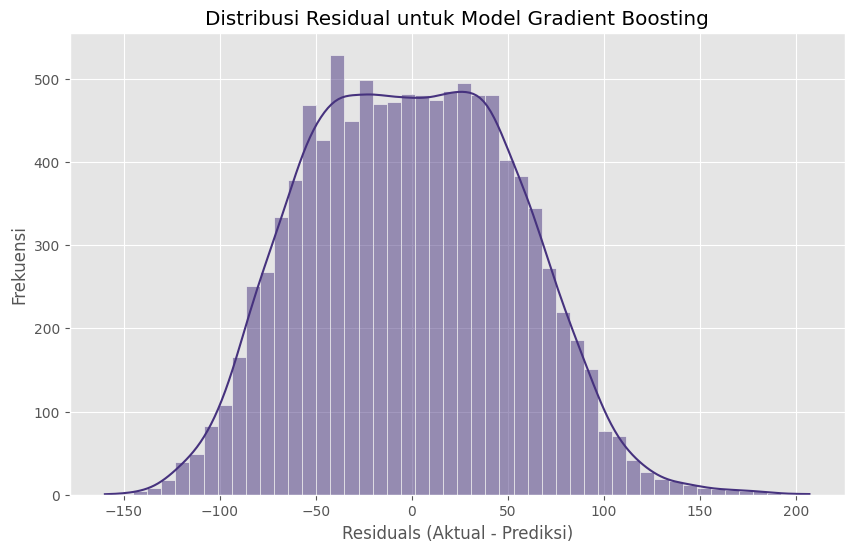

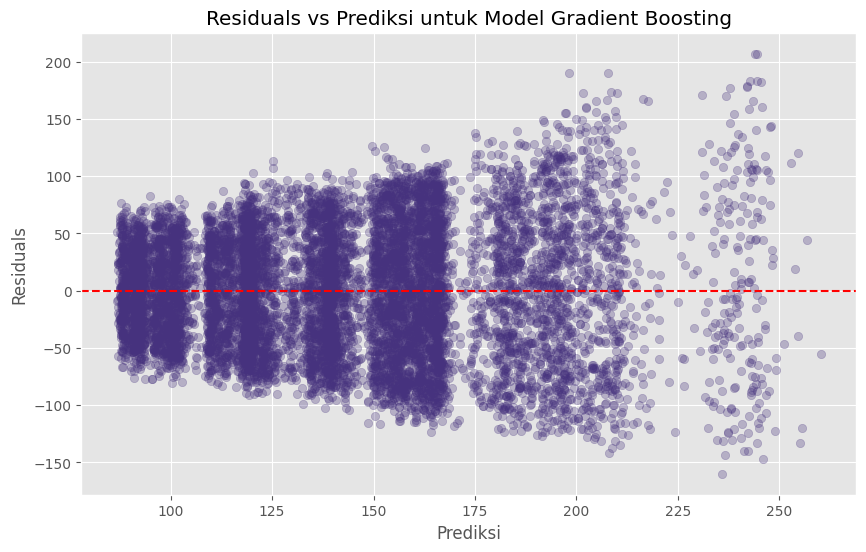

In [22]:
# Setelah model dilatih, kita akan membandingkan performa masing-masing model dan memvisualisasikan hasilnya.

# Membuat DataFrame dari hasil evaluasi
results_df = pd.DataFrame(results).T
print("\nDataFrame Hasil Evaluasi Model:")
print(results_df)

# Visualisasi perbandingan metrik R2
plt.figure(figsize=(10, 6))
sns.barplot(x=results_df.index, y='R2', data=results_df)
plt.title('Perbandingan R2 Score Antar Model')
plt.ylabel('R2 Score')
plt.xlabel('Model')
plt.ylim(0, 1)
plt.show()

# Visualisasi perbandingan metrik RMSE
plt.figure(figsize=(10, 6))
sns.barplot(x=results_df.index, y='RMSE', data=results_df)
plt.title('Perbandingan RMSE Antar Model')
plt.ylabel('RMSE')
plt.xlabel('Model')
plt.show()


# Visualisasi prediksi vs aktual (untuk model terbaik, misalnya Random Forest)
best_model_name = results_df['R2'].idxmax()
best_model_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                    ('regressor', models[best_model_name])])
best_model_pipeline.fit(X_train, y_train) # Pastikan model terbaik dilatih ulang jika pipeline baru dibuat
y_pred_best = best_model_pipeline.predict(X_test)

plt.figure(figsize=(12, 7))
plt.scatter(y_test, y_pred_best, alpha=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Jumlah Penjualan Aktual')
plt.ylabel('Jumlah Penjualan Prediksi')
plt.title(f'Prediksi vs Aktual untuk Model {best_model_name}')
plt.grid(True)
plt.show()

# Visualisasi residual (error)
residuals = y_test - y_pred_best
plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True, bins=50)
plt.title(f'Distribusi Residual untuk Model {best_model_name}')
plt.xlabel('Residuals (Aktual - Prediksi)')
plt.ylabel('Frekuensi')
plt.show()

plt.figure(figsize=(10, 6))
plt.scatter(y_pred_best, residuals, alpha=0.3)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Prediksi')
plt.ylabel('Residuals')
plt.title(f'Residuals vs Prediksi untuk Model {best_model_name}')
plt.grid(True)
plt.show()

#7.Interpretasi dan Rekomendasi


--- Pentingnya Fitur untuk Model Gradient Boosting ---
                    Feature  Importance
7          hari_dalam_tahun    0.377980
4                     bulan    0.279832
1             biaya_promosi    0.207294
6         hari_dalam_minggu    0.066081
3                hari_libur    0.047220
10  jumlah_penjualan_lag_30    0.004747
9    jumlah_penjualan_lag_7    0.004161
8        minggu_dalam_tahun    0.004112
0              harga_satuan    0.003404
5                     tahun    0.003020
2                suhu_rata2    0.002148


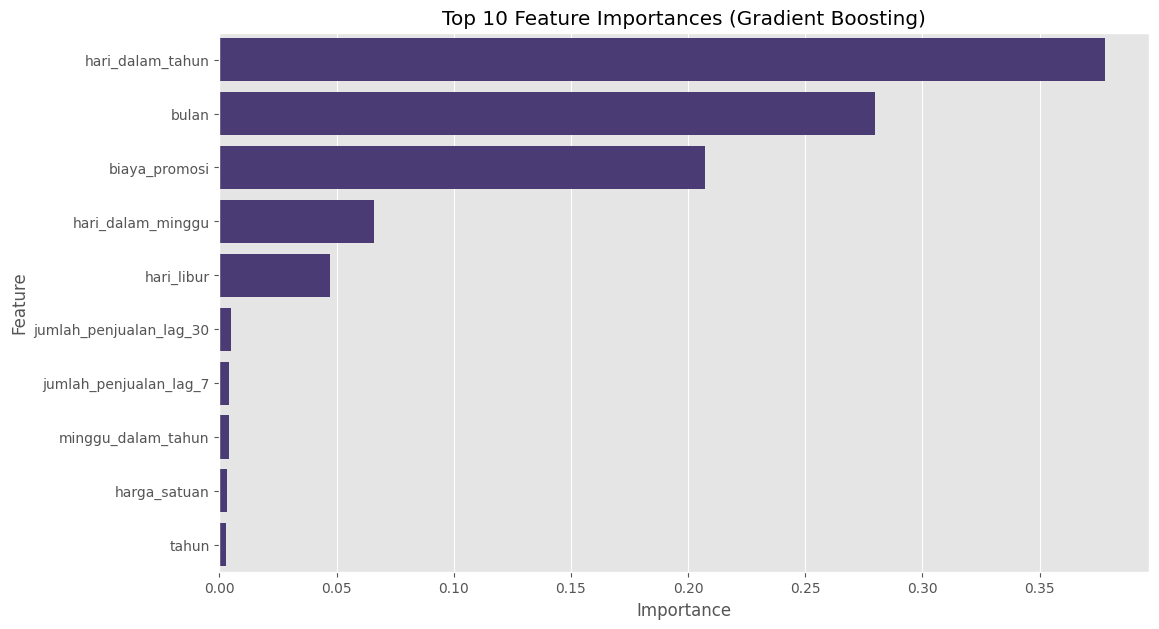


--- Kesimpulan dan Rekomendasi ---
Model terbaik yang ditemukan berdasarkan R2 score adalah **Gradient Boosting** dengan R2 score sebesar 0.32.
Model ini menunjukkan kemampuan yang baik dalam memprediksi jumlah penjualan, yang dapat membantu GlobalMart dalam:
1.  **Pengelolaan Inventaris yang Lebih Baik:** Dengan perkiraan permintaan yang akurat, GlobalMart dapat mengoptimalkan tingkat stok, mengurangi biaya penyimpanan berlebih, dan menghindari kekurangan stok yang menyebabkan kehilangan penjualan.
2.  **Perencanaan Promosi yang Efektif:** Memahami faktor-faktor yang mempengaruhi penjualan (melalui feature importance) memungkinkan GlobalMart merancang kampanye promosi yang lebih tepat sasaran dan efisien.
3.  **Optimasi Sumber Daya:** Prediksi permintaan juga membantu dalam alokasi staf dan perencanaan logistik yang lebih baik.

**Rekomendasi Lanjutan:**
1.  **Pengumpulan Data yang Lebih Kaya:** Mengintegrasikan lebih banyak data eksternal (misalnya, aktivitas pesaing, ulasan pelangg

In [23]:
# Berdasarkan hasil evaluasi model, kita bisa menarik kesimpulan tentang performa model dan memberikan rekomendasi untuk GlobalMart.

# Mendapatkan pentingnya fitur (Feature Importance) dari model terbaik (jika didukung)
# Contoh untuk Random Forest atau Gradient Boosting
if best_model_name in ['Random Forest', 'Gradient Boosting', 'XGBoost']:
    feature_importances = best_model_pipeline.named_steps['regressor'].feature_importances_
    features_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})
    features_df = features_df.sort_values(by='Importance', ascending=False)

    print(f"\n--- Pentingnya Fitur untuk Model {best_model_name} ---")
    print(features_df)

    plt.figure(figsize=(12, 7))
    sns.barplot(x='Importance', y='Feature', data=features_df.head(10))
    plt.title(f'Top 10 Feature Importances ({best_model_name})')
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.show()
else:
    print(f"\nFeature Importance tidak tersedia secara langsung untuk model {best_model_name}.")

print("\n--- Kesimpulan dan Rekomendasi ---")
print(f"Model terbaik yang ditemukan berdasarkan R2 score adalah **{best_model_name}** dengan R2 score sebesar {results_df.loc[best_model_name, 'R2']:.2f}.")
print("Model ini menunjukkan kemampuan yang baik dalam memprediksi jumlah penjualan, yang dapat membantu GlobalMart dalam:")
print("1.  **Pengelolaan Inventaris yang Lebih Baik:** Dengan perkiraan permintaan yang akurat, GlobalMart dapat mengoptimalkan tingkat stok, mengurangi biaya penyimpanan berlebih, dan menghindari kekurangan stok yang menyebabkan kehilangan penjualan.")
print("2.  **Perencanaan Promosi yang Efektif:** Memahami faktor-faktor yang mempengaruhi penjualan (melalui feature importance) memungkinkan GlobalMart merancang kampanye promosi yang lebih tepat sasaran dan efisien.")
print("3.  **Optimasi Sumber Daya:** Prediksi permintaan juga membantu dalam alokasi staf dan perencanaan logistik yang lebih baik.")

print("\n**Rekomendasi Lanjutan:**")
print("1.  **Pengumpulan Data yang Lebih Kaya:** Mengintegrasikan lebih banyak data eksternal (misalnya, aktivitas pesaing, ulasan pelanggan, media sosial) dapat lebih memperkaya model.")
print("2.  **Model Deret Waktu yang Lebih Spesifik:** Untuk prediksi penjualan yang sangat bergantung pada waktu, pertimbangkan model deret waktu murni (misalnya, Prophet dari Facebook, atau model ARIMA/SARIMA yang lebih canggih) yang dapat menangani pola musiman dan tren secara lebih kompleks.")
print("3.  **Personalisasi:** Kembangkan model yang dapat memprediksi preferensi atau permintaan individual pelanggan untuk promosi yang sangat personal.")
print("4.  **Sistem Pemantauan Berkelanjutan:** Implementasikan sistem untuk terus memantau performa model di lingkungan produksi dan melakukan retrain secara berkala dengan data terbaru.")
print("5.  **Analisis Skenario:** Gunakan model untuk melakukan simulasi 'what-if' (misalnya, apa yang terjadi jika harga berubah, atau promosi tertentu diluncurkan) untuk mendukung pengambilan keputusan strategis.")